In [2]:
import json
import sys
import numpy as np
#importing the json data
with open("C:/Users/osman/Desktop/coding/Drunk Elephant C-Firma Day Serum.json") as file:
    data = json.load(file)

In [2]:
#aha! the json data is a dictionary split between the 3 review sources.
print(data['Drunk Elephant C-Firma Day Serum'].keys())


##NOTES:
# So far, I've put some generic words (good, love, etc.) into the word banks for each category. But that's a cheap shortcut.
# Someone could be using good to indicate texture, efficacy, or just general goodness.
# A more rigorous approach:
#    run sentiment analysis per sentence
#    have word banks for each category (positive, negative, or neutral) to associate each sentence to a category
#    one sentence category ID'd, use final word bank of generic words (love, good, horrible) to further qualify degree of sentiment


dict_keys(['influenster', 'makeupAlley', 'sephora'])


In [3]:
iReviews = data['Drunk Elephant C-Firma Day Serum']['influenster'] #focusing solely on influenster reviews for now.
print(iReviews[0].keys())
print(iReviews[1])

#some negative influenster reviews: 156, 1580, 7

dict_keys(['date', 'stars', 'text', 'profile'])
{'date': 'Dec. 17, 2017, 2:34 a.m.', 'stars': '5', 'text': 'Buckle in, it\'s gonna be a long one! Let me start by saying that I am a huge fan of Drunk Elephant products -they are AH-MAZ-ZING!!! They use VERY high quality ingredients that perform very well! The ONLY complaint that I have is that the cost of these products are extremely high, which is unfortunate for a LOT of us out here that want & NEED a high quality, skincare regimen, for daily/nightly use - one that gives us actual results, yet we can not afford it - at least not afford enough items for an ENTIRE skincare regimen - and I\'m just talking the skincare basics, not the extra skincare "luxuries" (which if I could afford it, in my mind, they would immediately go from a "luxury" and turn into a NEED because they are SO GOOD!!!) And you can forget about being able to afford to keep replenishing these products, when being used on a regular basis, as directed.  💸😔 HIGH QUALITY sk

In [42]:
#number of times a particular term is found in review body
def countTerm(reviews,term):
    count = 0
    for item in reviews:
        if term in item['text']:
            count = count + 1
    return count

#returns indices of reviews possessing this term
def reviewIndex(reviews,term):
    hits = []
    count = 0
    for review in reviews:
        if term in review['text']:
            hits.append(count)
        count = count + 1
    return hits

#prints all reviews with indices listed in "hits"
def printReviews(reviews,hits):
    for count in hits:
        print(reviews[count]['text'])
    return
        
import re
#taken from https://stackoverflow.com/questions/4576077/python-split-text-on-sentences
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

#splits text into separate sentences - will be important later!
def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

#quick and dirty test to ID reviews that dislike texture vs like texture
def textureTest(text):
    goodWords = ['smooth','radiant','moisturized','consistency','consistent','amazing','absorbed','seeps','fast acting','light','comfortable','good','healthy','love','loving','bright','wrinkle','wrinkly']
    badWords  = ['oily','greasy','shiny','residue','heavy','sticky','stickiness','tacky','odd','sticky forever','itchy','hate','annoying','liquefy','clog','drying','burn','peeling','gritty','irritate','suck','stings','stiff','film']
    goodCount = 0
    badCount  = 0
    
    for word in goodWords:
        goodCount = goodCount + text.count(word) - text.count("not " + word) - text.count("n't "+word) - 2*text.count("never "+ word)
    for word in badWords:
        badCount  = badCount  + text.count(word) - text.count("not " + word) - text.count("n't "+word) - 2*text.count("never "+ word)
        
    return(goodCount-badCount)


#quick and dirty test to ID reviews that say this product is effective vs ineffective
def efficacyTest(text):
    goodWords = ['worth it','visible','results','nicer','really liked','really works','visibly','enriching','love it','powerful','value','favorite','amazing','well worth','worth','repurchase','helped reduce','compliment','fast acting','would recommend','hooked','good','effective','useful','change','quality','amazing','incredible','love','help','excellent','healthy','potent','love','loving','improve','like']
    badWords  = ['horrible','difficult','unfortunately','doubt','not sure','let down','garbage','hate','disappoint','ineffective','useless','defective','expired','broken','gimmick','break out','upset','nightmare','wrong','do not use','broke out','returned','regret','shame']
    goodCount = 0
    badCount  = 0
    
    for word in goodWords:
        goodCount = goodCount + text.count(word) - 2*text.count("not " + word) - 2*text.count("n't "+word) - 2*text.count("never "+ word)
    for word in badWords:
        badCount  = badCount  + text.count(word) - 2*text.count("not " + word) - 2*text.count("n't "+word) - 2*text.count("never "+ word)
    
    return(goodCount-badCount)

#quick and dirty test to ID reviews that say this product plays nice w/ makeup vs note
def makeupTest(text):
    goodWords = ['played well','mix','ease','healthy','apply','last','great','good','love','like','fine']
    neutWords = ['react','layer','apply','makeup','cosmetic','underneath makeup','primer','foundation','routine','under','over','before','wear']
    badWords  = ['difficult','shiny',"can't wear",'not putting makeup','liquefy','ruined','nightmare','balling','affect','bleed','blot','slip','pills','hate']
    goodCount = 0
    badCount  = 0
    neutCount = 0
    
    for word in goodWords:
        goodCount = goodCount + text.count(word) - 2*text.count("not " + word) - 2*text.count("n't "+word) - 2*text.count("never "+ word)
    for word in badWords:
        badCount  = badCount  + text.count(word) - 2*text.count("not " + word) - 2*text.count("n't "+word) - 2*text.count("never "+ word)
    for word in neutWords:
        neutCount = neutCount + text.count(word)
    
    if neutCount<2:
        neutCount=0
    if ((goodCount-badCount)*(goodCount-badCount))<5:
        neutCount=0
    
    return((goodCount-badCount)*neutCount)

In [45]:
print(countTerm(iReviews,"n't" + " feel"))
hits = reviewIndex(iReviews,"sticky")

11


In [ ]:
for review in hits:
    print(iReviews[review]['text'])
    print(iReviews[review]['stars']+" stars")
    print(textureTest(iReviews[review]['text']))

In [53]:
scoreListTexture = []
for review in iReviews[:2600]:
    score = textureTest(review['text'])
    scoreListTexture.append(score)
    if review['stars']=='5' and score<0:
        score = score/2
    elif int(review['stars'])<5 and score<0:
        score = score * (6-int(review['stars']))
    elif review['stars']=='5' and score>0:
        score = score+1
    if score >3:
        print(review['text'])
        print(review['stars']+ " stars")
        print("good texture! score of "+ str(score))
    if score <-3:
        print(review['text'])
        print(review['stars']+ " stars")
        print("bad texture! score of "+ str(score))

This product has absolutely changed my skin. I had been so hesitant for so long about buying Drunk Elephant products. However, I can say that after years of consistently investing in my skincare that their products have been the most effective I have ever used. I had recently used an AHA product from a different brand and my skin went haywire. It caused me terrible texture and a few blemishes. I scrapped that product and began using DE’s Framboos Glycolic Serum at night and the DE C-Firma during the day. My skin complexion and tone has never looked better. I feel the C-Firma has helped fade away those post-blemish spots I always get and completely evened out my skin tone after only 1 week of continuous use. I am getting married in June so I needed something to work quickly on my skin and help me bounce back. This is a product that has worked wonders for me. There are only two downsides to this product: 1. Price and 2. Scent. This serum has a hefty price tag but I can vouch for its qual

good texture! score of 4
This serum works extremely well. You see results after a couple weeks of usage. It’s really hydrating and absorbs pretty well without making your skin feel tacky or oily. I docked a star because I can’t stand the scent! I don’t think I’m going to repurchase since the scent bothers me quite a lot. It’s really strong! But if you can stand the scent, this serum works great!
4 stars
bad texture! score of -4
I’ve noticed an amazing difference in my discoloration and brightness of my skin. I use it as directed, once a day in the mornings on to clean skin and I love the way it smells like orange peel. The ingredients and brand are amazing clean and trustworthy. I only knocked off a star for the price. You pay for what you get but holy cow the price is a gut punch!
4 stars
good texture! score of 4
I love the brand, ingredients, packaging, and effectiveness. I love using this serum in the morning under my moisturizer. I find that it really helps with lightening dark spo

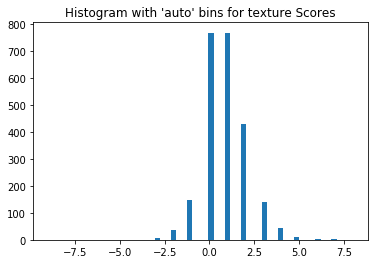

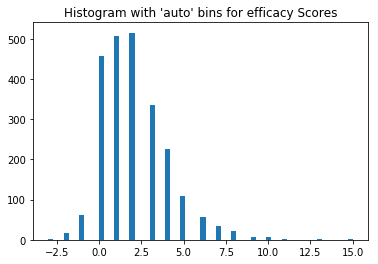

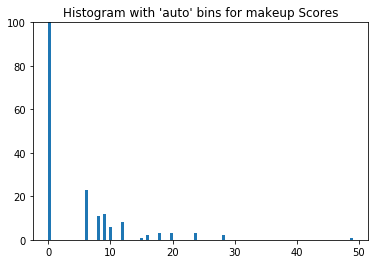

In [60]:
import matplotlib.pyplot as plt

#np.histogram(scoreList)

plt.hist(scoreListTexture, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins for texture Scores")
plt.show()

plt.hist(scoreListEfficacy, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins for efficacy Scores")
plt.show()

plt.hist(scoreListMakeup, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins for makeup Scores")
plt.ylim(0,100)
plt.show()


In [52]:
scoreListEfficacy = []
for review in iReviews[:2600]:
    score = efficacyTest(review['text'])
    scoreListEfficacy.append(score)
    if review['stars']=='5' and score<0:
        score = score/2
    elif int(review['stars'])<5 and score<0:
        score = score * (6-int(review['stars']))
    if score >3:
        print(review['text'])
        print(review['stars']+ " stars")
        print("really effective! score of "+ str(score))
    if score <-3:
        print(review['text'])
        print(review['stars']+ " stars")
        print("really not effective! score of "+ str(score))

This product has absolutely changed my skin. I had been so hesitant for so long about buying Drunk Elephant products. However, I can say that after years of consistently investing in my skincare that their products have been the most effective I have ever used. I had recently used an AHA product from a different brand and my skin went haywire. It caused me terrible texture and a few blemishes. I scrapped that product and began using DE’s Framboos Glycolic Serum at night and the DE C-Firma during the day. My skin complexion and tone has never looked better. I feel the C-Firma has helped fade away those post-blemish spots I always get and completely evened out my skin tone after only 1 week of continuous use. I am getting married in June so I needed something to work quickly on my skin and help me bounce back. This is a product that has worked wonders for me. There are only two downsides to this product: 1. Price and 2. Scent. This serum has a hefty price tag but I can vouch for its qual

5 stars
really effective! score of 6
I liked this a lot, but I just can’t justify the price tag of the full size item. It made my skin feel really soft and did brighten but I was expecting more for the price tag. I would recommend only if you’ve gotten the smaller size and loved it... otherwise it’s too expensive to take a chance on!
4 stars
really effective! score of 4
First of all, I think mine arrived oxidized since it was dark orange when I got it. Second of all, I saw someone online refer to the smell of this as smelling like hot dogs, and omg - IT DOES. And tbh, I just really don't want to put anything that smells like hot dogs on my face! You'd think, for the price, they could maybe play around with altering the scent a bit so it doesn't smell so strongly of hot dogs, lol. If the smell doesn't bother you and your product doesn't arrive oxidized, you might like this product, but for those two reasons I was unable to really give this product a good try and wouldn't try it again in

5 stars
really effective! score of 6
I got this in the VIB sale at Sephora and fell in love. One pump is all you need! The pump also twists to hide so it’s protected from light exposure. I have red acne and it’s helped tone that down. I use it every morning. I also love the packaging! Will repurchase for sure!
5 stars
really effective! score of 6
This has been the #1 skin care item I’ve been dying to try because I have been obsessed with vitamin c. And I do want to say I love it! It makes my skin feel healthy. Just pricey
5 stars
really effective! score of 4
I apply this serum before I apply my makeup and I love it. The serum is nice and it feels really good on the skin. I have super sensitive skin and was worried this might break me it because that tends to happen but it didn’t for me. I loved it so much and loved the results after a month that I bought one for my mom and now she loves it too!
5 stars
really effective! score of 11
This product is pricey, which I was skeptical about at

In [51]:
scoreListMakeup = []
for review in iReviews[:2600]:
    score = makeupTest(review['text'])
    scoreListMakeup.append(score)
    if review['stars']=='5' and score<0:
        score = score/2
#    elif int(review['stars'])<5 and score<0:
#        score = score * (6-int(review['stars']))
    if score >5:
        print(review['text'])
        print(review['stars']+ " stars")
        print("fine with Makeup! score of "+ str(score))
    if score <-5:
        print(review['text'])
        print(review['stars']+ " stars")
        print("not good with Makeup! score of "+ str(score))

So I have avoided this brand pretty harshly. I have loved high end makeup and skincare since before it was trendy and then when things got trendy the quality dropped and everything was hyped up. Even in skincare companies weren't worried about the quality and performance they just wanted to churn out the next hyped up must have. Usually those things only stay wanted for about 5 min before every one figures out it wasn't all they said it would be and move on to the next thing. I felt this brand was overpriced and gimmicky and I spend a lot of money on my skincare but it's usually with more well established brands like dior.  So anyway I have adult hormonal Acne that hasn't changed since the start of puberty so its basically teen acne that never went away. Its not severe but I am constantly breaking out. I also have such oily skin that I have to use 2 to 4 blotting sheets every hour. But aside from that my pores are large and I'm getting fine lines around my eyes when I smile.  I'm 27 bu

5 stars
fine with Makeup! score of 9
I want to love this...but it falls a little flat for me. I can't tell that it's doing a ton, but my overall skin tone has improved. Just not sure it's due to this product since I started several things at once. I love lots of things about DE- no fragrance, great ingredients and superb packaging (keeps ingredients stable and active). I don't think I care much for the consistency of this serum, it's more like an oil. It does soak in quickly and I haven't had any problem with pilling. I don't know, it's my first vit C serum (which I apply before sunscreen for maximum effect), maybe I need to try a few others to see if this is my Holy Grail or not. Give it a try, you may love it.
3 stars
fine with Makeup! score of 18
Yes, it works! It smells very nice, like oranges. It is a very nice serum, but I have found that there are some others I like just as much. I like the Truth Serum from Ole Hendrickson a little more the Drunk Elephant. I find it to spread a 